In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import gdown
from zipfile import ZipFile

In [18]:
data= tf.keras.utils.image_dataset_from_directory('DataB_pepper', label_mode = None,  batch_size = 16, image_size = (32,32))
len(data)
data = data.map(lambda x: x/255)

Found 4445 files belonging to 1 classes.


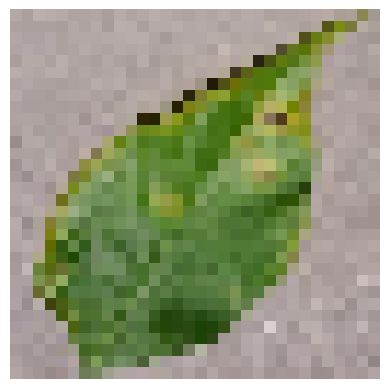

In [19]:
for x in data:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [20]:
#data_iterator = data.as_numpy_iterator()
#batch = data_iterator.next()
# class 0 in the batch is real images of the plants
# shape of the images is (128,64,64,3)
# batch size is 128


In [21]:
type(data)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [22]:
################# DISCRIMINATOR NETWORK ######################
# model name
discriminator = keras.Sequential(name = "discriminator")
# input layer
discriminator.add(keras.Input(shape=(32,32,3),))
# hidden layer 1
discriminator.add(layers.Conv2D(64, kernel_size = (4,4), strides = (2,2), padding="same"))
discriminator.add(layers.LeakyReLU(0.2))
# hidden layer 2
discriminator.add(layers.Conv2D(128, kernel_size = (4,4), strides = (2,2), padding="same"))
discriminator.add(layers.LeakyReLU(0.2))
# hidden layer 3
discriminator.add(layers.Conv2D(128, kernel_size = (4,4), strides = (2,2), padding="same"))
discriminator.add(layers.LeakyReLU(0.2))
# output layer 
discriminator.add(layers.Flatten())
discriminator.add(layers.Dropout(0.2))
discriminator.add(layers.Dense(1, activation="tanh"))
# summary of the model
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        3136      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)         262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)            

In [23]:
# from tensorflow.keras.utils import plot_model
# plot_model(discriminator, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
#################### GENERATOR NETWORK ###########################
generator = keras.Sequential()
# input layer
generator.add(layers.Input(shape=(128),))
# hidden layer 1 ~ staring with 8 * 8 * 128
generator.add(layers.Dense(8 * 8 * 128))
generator.add(layers.Reshape((8,8,128)))
# hidden layer 2 ~ upsampling to 16 * 16
generator.add(layers.Conv2DTranspose(128, kernel_size = (4,4), strides = (2,2), padding = "same"))
generator.add(layers.LeakyReLU(0.2))
# hidden layer 3 ~ upsampling to 32 * 32
generator.add(layers.Conv2DTranspose(256, kernel_size = (4,4), strides = (2,2), padding= "same"))
generator.add(layers.LeakyReLU(0.2))
# hidden layer 4 ~ upsampling to 64 * 64
#generator.add(layers.Conv2DTranspose(512, kernel_size = (4,4), strides = (2,2), padding = "same"))
#generator.add(layers.LeakyReLU(0.2))
# output layer 
generator.add(layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"))

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 3)        

In [25]:
##################### TRAINING LOOP #######################

##### SET UP LOSS AND OPTEMIZERS 
from tensorflow.keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

# DCGAN pepper
g_opt = Adam(learning_rate = 0.00025)
d_opt = Adam(learning_rate = 0.000070)

# strawberry
# g_opt = Adam(learning_rate = 0.00035)
# d_opt = Adam(learning_rate = 0.000075)

# g_opt = Adam(learning_rate = 0.00045)
# d_opt = Adam(learning_rate = 0.000075)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()


class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_opt, g_opt, d_loss, g_loss):
        super().compile()
        self.d_opt = d_opt
        self.g_opt = g_opt
        self.d_loss = d_loss
        self.g_loss = g_loss
        


    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        
        # Combine them with real images
        #combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        #labels = tf.concat(
        #    [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        #)
        # Add random noise to the labels - important trick!
        #labels += 0.10 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:   
            #predictions = self.discriminator(combined_images)
            #total_d_loss = self.d_loss(labels, predictions)
            is_real = self.discriminator(real_images, training = True)
            is_gen = self.discriminator(generated_images, training = True)
            combined = tf.concat([is_real, is_gen], axis = 0)
            Lable_combined = tf.concat([tf.zeros_like(is_real), tf.ones_like(is_gen)], axis = 0)
            
#             noise_real = tf.random.uniform(tf.shape(is_real))
#             noise_gen =  tf.random.uniform(tf.shape(is_gen))
            
            noise_real = 0.25 * tf.random.uniform(tf.shape(is_real))
            noise_gen = -0.15 * tf.random.uniform(tf.shape(is_gen))
#             noise_gen = -0.25 * tf.random.uniform(tf.shape(is_gen))
            
            Lable_combined += tf.concat([noise_real, noise_gen], axis = 0)
            total_d_loss = self.d_loss(Lable_combined, combined)
            
        grads = tape.gradient(total_d_loss, self.discriminator.trainable_weights)
        self.d_opt.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            total_g_loss = self.g_loss(misleading_labels, predictions)
        grads = tape.gradient(total_g_loss, self.generator.trainable_weights)
        self.g_opt.apply_gradients(zip(grads, self.generator.trainable_weights))

        
        return {
            "d_loss": total_d_loss,
            "g_loss": total_g_loss,
        }


In [26]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join('DCGAN_Bacterial_trial', f'generated_img_epoch_{epoch}_{i}.png'))

In [27]:
epochs = 100
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=128)
gan.compile(d_opt, g_opt, d_loss, g_loss)
gan.fit(data, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=128)])

Epoch 1/100
278/278 [==============================] - 12s 39ms/step - d_loss: 1.4231 - g_loss: 0.2029
Epoch 2/100
278/278 [==============================] - 9s 31ms/step - d_loss: 0.8690 - g_loss: 0.5522
Epoch 3/100
278/278 [==============================] - 9s 31ms/step - d_loss: 0.7924 - g_loss: 0.6407
Epoch 4/100
278/278 [==============================] - 9s 31ms/step - d_loss: 0.7668 - g_loss: 0.6643
Epoch 5/100
278/278 [==============================] - 9s 30ms/step - d_loss: 0.7495 - g_loss: 0.6906
Epoch 6/100
278/278 [==============================] - 9s 31ms/step - d_loss: 0.7349 - g_loss: 0.7039
Epoch 7/100
278/278 [==============================] - 9s 31ms/step - d_loss: 0.7319 - g_loss: 0.7063
Epoch 8/100
278/278 [==============================] - 9s 31ms/step - d_loss: 0.7296 - g_loss: 0.7179
Epoch 9/100
278/278 [==============================] - 9s 31ms/step - d_loss: 0.7286 - g_loss: 0.7043
Epoch 10/100
278/278 [==============================] - 9s 31ms/step - d_loss: 0.

278/278 [==============================] - 9s 31ms/step - d_loss: 0.6921 - g_loss: 0.7720
Epoch 81/100
278/278 [==============================] - 9s 31ms/step - d_loss: 0.6937 - g_loss: 0.7952
Epoch 82/100
278/278 [==============================] - 9s 31ms/step - d_loss: 0.6930 - g_loss: 0.7730
Epoch 83/100
278/278 [==============================] - 9s 31ms/step - d_loss: 0.6867 - g_loss: 0.7814
Epoch 84/100
278/278 [==============================] - 9s 31ms/step - d_loss: 0.6919 - g_loss: 0.7881
Epoch 85/100
278/278 [==============================] - 9s 31ms/step - d_loss: 0.6890 - g_loss: 0.7923
Epoch 86/100
278/278 [==============================] - 9s 31ms/step - d_loss: 0.6871 - g_loss: 0.7891
Epoch 87/100
278/278 [==============================] - 9s 31ms/step - d_loss: 0.6881 - g_loss: 0.7904
Epoch 88/100
278/278 [==============================] - 9s 31ms/step - d_loss: 0.6881 - g_loss: 0.7839
Epoch 89/100
278/278 [==============================] - 9s 31ms/step - d_loss: 0.6936 

In [28]:
random_latent_vectors = tf.random.normal(shape=(16, 128))
generated_images = generator.predict(random_latent_vectors)
generated_images *= 255
for i in range(16):
    img = keras.preprocessing.image.array_to_img(generated_images[i])
    img.save(os.path.join('DCGAN_GEN', f'generated_img_epoch_{i}.png'))

In [31]:
generator.compiled_metrics == None
generator.compile()
generator.save('generator_bacterial_pepper_DCGAN.h5')

In [33]:
loaded_gen = keras.models.load_model('generator_bacterial_pepper_DCGAN.h5')

In [34]:
random_latent_vectors2 = tf.random.normal(shape=(2000, 128))
generated_images = loaded_gen.predict(random_latent_vectors2)
generated_images *= 255
for i in range(2000):
    img = keras.preprocessing.image.array_to_img(generated_images[i])
    img.save(os.path.join('DCGAN_pepper_bacterial_final', f'generated_img_epoch_{i}.png'))

In [44]:
print(random_latent_vectors)

tf.Tensor(
[[ 1.5347177  -0.7065127  -1.6114981  ... -2.287704   -0.8297936
  -0.47491738]
 [-0.0037844  -0.08391918  0.1929763  ...  0.9431547   1.1112481
   0.49122465]
 [ 0.37282747  0.705518   -0.1990936  ...  0.11986952 -0.6540281
  -0.97849387]
 ...
 [ 0.4873934  -1.0083574   0.28027666 ... -0.6912557   1.2657646
   2.5886927 ]
 [ 0.93032753  1.0765502  -0.83591175 ... -0.8548026   0.37978745
  -1.2077094 ]
 [-0.7782833   0.38312474  2.338798   ... -0.47822246 -0.03043891
   1.2092308 ]], shape=(16, 128), dtype=float32)
